# Overview

In this notebook we will implement a retrieval + QA system. The input to the system is multiple (potentially long) documents and a question. The output is an answer and optionally a list of paragraphs that support the answer.

This pipeline typically comprises the following steps:
1. Sliding window: segment the documents into passages of N (e.g., 10) sentences.
2. Indexing: create an inverted index, i.e., a data structure that allows us to efficiently retrieve passages that contain one of more words present in the question.
3. Retrieval: use BM25 to retrieve passages that are likely relevant to the question.
4. Reranking: use miniLM to rerank the passages retrieved in step 3. The goal of this step is to select more relevant passages to use as input to step 5.
5. Question-answering: use a zero/few-shot language model such as FLAN-T5 to answer the question based on the passages selected in step 4.


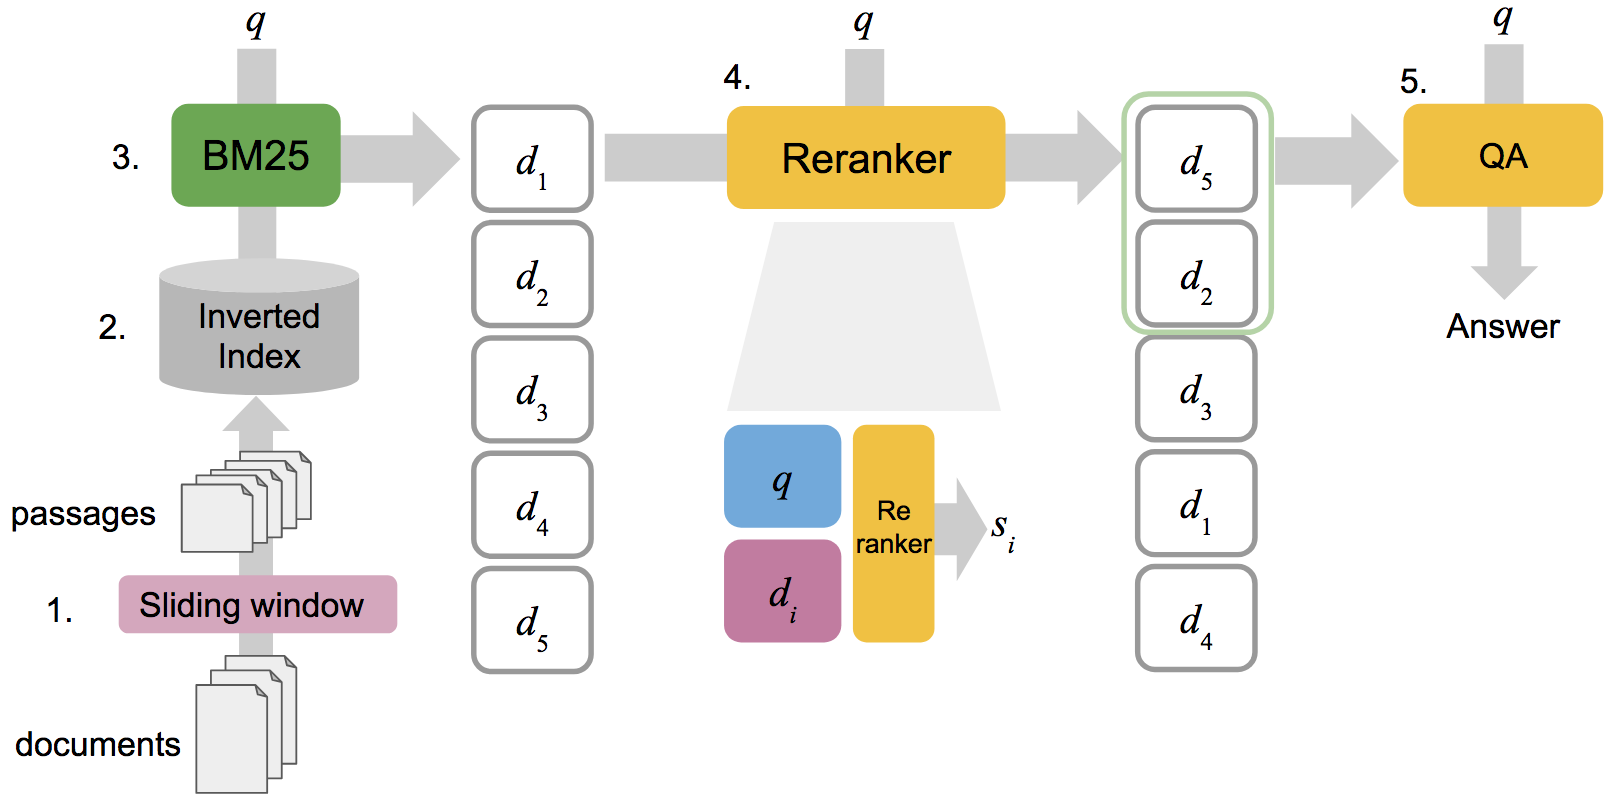

We will be using the [Financial QA (FiQA) dataset](https://huggingface.co/datasets/BeIR/fiqa), whose goal is to answer questions based on financial documents.

For simplicity, we will skip steps 1 and 2. They we will be revisited in the next sessions.

**Assignment:** search for `TODO:` in the cells and write your code to accomplish the task.

Hardware requirements:
- This notebook was tested on a machine with 24GB of RAM.
- It does not need a GPU, but the QA step using FLAN-T5 will take minutes.

## Installing Java on the notebook

In [ ]:
import os
#%%capture
!curl -O https://download.java.net/java/GA/jdk11/9/GPL/openjdk-11.0.2_linux-x64_bin.tar.gz
!mv openjdk-11.0.2_linux-x64_bin.tar.gz /usr/lib/jvm/; cd /usr/lib/jvm/; tar -zxvf openjdk-11.0.2_linux-x64_bin.tar.gz
!update-alternatives --install /usr/bin/java java /usr/lib/jvm/jdk-11.0.2/bin/java 1
!update-alternatives --set java /usr/lib/jvm/jdk-11.0.2/bin/java
os.environ["JAVA_HOME"] = "/usr/lib/jvm/jdk-11.0.2"

# Installing required packages

In [ ]:
!pip install transformers  # Used by the reranker and QA models
!pip install bitsandbytes accelerate  # Needed to run FLAN-T5 in machines with low RAM
!pip install pyserini  # To retrieve documents using BM25
!pip install faiss-cpu  # Needed by pyserini, but we will not use dense retrieval in this notebook.
!pip install sentence_transformers==2.2.2  # To rerank with miniLM

# Setting the device

Make sure you are using a GPU runtime. It is fine to use a CPU, but it is very slow.

In [ ]:
!nvidia-smi

In [ ]:
import torch

if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

# 1 - Preprocessing

In this step, we format the segment documents in passages using a sliding window approach (e.g., windows of 10 sentences, stride of 5 sentences).

Since the documents of FiQA dataset were already indexed in pyserini, we will skip this step. In the next sessions, we will revisit problem of dealing with long documents and will implementer a sliding window function.

Question: Why do we need to split documents into shorter segments?

**Write your answer here.**

# 2 - Indexing

We will use pyserini to index the documents. We typically deal with hundreds of thousands of documents, but to make this assignment simpler, we will use the already indexed FiQA collection.

Question: is there a problem when the index comprises only a few documents?

**Write your answer here.**

# 3 - Sparse Retrieval

In this step, we retrieve 100 passages for question using the BM25.

In [ ]:
# We first define the question that will be issued to our pipeline
question = 'What is considered a business expense on a business trip?'

## Initializing the LuceneSearcher

In [ ]:
from pyserini.search import LuceneSearcher

# LuceneSearcher defaults to BM25 scoring function.
searcher = LuceneSearcher.from_prebuilt_index('beir-v1.0.0-fiqa-flat')

## Retrieving

In [ ]:
# Write your code here.
import json

hits = searcher.search(question, k=100)
texts = []
for i, hit in enumerate(hits[:10]):
    text = json.loads(hit.raw)['text']
    texts.append(text)
    if i < 10:  # Only print the top 10.
        print(f'{i+1:2}{hit.docid:8} {hit.score:.5f}  {text}')

# 4 - Rerank

In this step, we will rerank the 100 documents retrieved in the previous step using miniLM finetuned on MS MARCO. We keep only the top 3 documents that will be used in the QA step.

## Initializing the reranker

In [ ]:
import sentence_transformers

reranker = sentence_transformers.CrossEncoder('cross-encoder/ms-marco-MiniLM-L-2-v2', max_length=512, device=device)

## Scoring and Reranking

In [ ]:
from typing import List


def rerank(model, query: str, texts: List[str]) -> List[str]:
    # TODO:
    # Write your code here to rescore and rerank passages using miniLM.
    return texts_scores
        
texts_scores = rerank(model=reranker, query=question, texts=texts)

max_docs = 1
top_texts = []
for i, (text, score) in enumerate(texts_scores[:max_docs]):
    top_texts.append(text)
    print(f'{i+1:2} {score:.5f} {text}')

# 5 - Question-answering

Finally, we will use FLAN-T5 in a zero/few-shot setting to answer the question given the top ranked document in step 4 as context.

## Instantiating FLAN-T5

In [ ]:
## We need this for the pip's dependency resolver to take into account all the packages that are installed to activate pip dependancy resolver
# !pip install h5py
# !pip install typing-extensions
# !pip install wheel

In [ ]:
# !pip install git+https://github.com/huggingface/transformers.git

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base", torch_dtype=torch.float16, low_cpu_mem_usage=True)

# In case you have a machine with more memory, try the XL (3B parameters) version:
# tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-xl")
# Downloading the model takes 5-10 minutes.
# model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-xl", torch_dtype=torch.float16, low_cpu_mem_usage=True)

model = model.to(device)

## Generating the answer

In [ ]:
# TODO:
# Write your prompt here. It should contain one or more examples with their respective answer followed by the question and
# the context that we want to answer.
prompt = """"""

context = ' '.join(top_texts)
input_text = prompt.format(context=context, question=question)
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to(device)
gen_tokens = model.generate(
    input_ids,
    do_sample=False,
    max_length=128)
output_text = tokenizer.decode(gen_tokens[0], skip_special_tokens=True)

print(f"Question: {question}")
print(f"Context: {context}")
print(f"Model's Answer: {output_text}")